In [1]:
import os
import importlib.util

from localdynamics import derivative, local_dynamics
from localdynamics.plotting import plot, plot2

import jax
from jax import random
from jax import numpy as jnp

import numpy as np

from matplotlib import pyplot as plt

jax.config.update('jax_platforms', 'cpu')
jax.config.update("jax_default_device", jax.devices('cpu')[0])

In [2]:
def load_data(max_time_dim=2000):
    data_root = "data"
    datasets = []
    
    # Iterate through each dataset directory
    for dataset_dir in os.listdir(data_root):
        dataset_path = os.path.join(data_root, dataset_dir)
        if os.path.isdir(dataset_path):  # Ensure it's a directory
            import_file = os.path.join(dataset_path, "import_data.py")
            
            if os.path.isfile(import_file):  # Ensure import_data.py exists
                # Dynamically import the import_data.py module
                spec = importlib.util.spec_from_file_location("import_data", import_file)
                module = importlib.util.module_from_spec(spec)
                spec.loader.exec_module(module)
                
                # Call the import_data() function
                if hasattr(module, "import_data"):
                    datasets = datasets + module.import_data(max_time_dim=max_time_dim)
                else:
                    print(f"No function 'import_data' found in {import_file}")
            else:
                print(f"No file 'import_data.py' found in {dataset_path}")
                
    return datasets

In [3]:
max_time_dim = 1000

datasets = load_data(max_time_dim)

for d in datasets:
    print(f'{d['name']}, xs:{d['xs'].shape}, ts:{d['ts'].shape}')

Motor cortex (Monkey Cousteau), xs:(1000, 74), ts:(1000,)
Muscle (Monkey Cousteau), xs:(1000, 17), ts:(1000,)
Motor cortex (Monkey Drake), xs:(962, 52), ts:(962,)
Muscle (Monkey Drake), xs:(962, 33), ts:(962,)
Fish, xs:(1000, 302), ts:(1000,)


In [4]:
z_score = True

if z_score:
    for d in datasets:
        d['xs'] = (d['xs'] - d['xs'].mean(axis=0, keepdims=True))/(d['xs'].std(axis=0, keepdims=True) + 10**-8)

In [ ]:
#nb_neighbors = np.logspace(1, 8, 8, 2**8, base=2, dtype=int)
nb_neighbors = np.linspace(1, 201, 201, dtype=int)

print(f'Number of neighbors: {nb_neighbors}')

for d in datasets:
    print(d['name'])
    d['dxs_dts'] = derivative(d['ts'][1]-d['ts'][0], d['xs'], accuracy=2)
    d['local_dxs_dts'] = local_dynamics(d['xs'], d['dxs_dts'], number_of_neighbors=np.max(nb_neighbors), unit_length=False, distance_scaling=None)
    #d['local_xs'] = local_dynamics(d['xs'], d['xs'], number_of_neighbors=np.max(nb_neighbors), unit_length=False, distance_scaling=None) - d['xs'][..., jnp.newaxis, :]
    d['sv_local_dxs_dts'] = jnp.stack([jnp.concatenate([jnp.linalg.svd(d['local_dxs_dts'][..., :, :k], full_matrices=False, compute_uv=False), 
                                                        jnp.full((d['local_dxs_dts'].shape[0], min(np.max(nb_neighbors), d['local_dxs_dts'].shape[-1]) - min(k, d['local_dxs_dts'].shape[2]),), jnp.nan)], axis=-1) for k in nb_neighbors])


Number of neighbors: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199 200 201]
Motor cortex (Monkey Cousteau)


[]

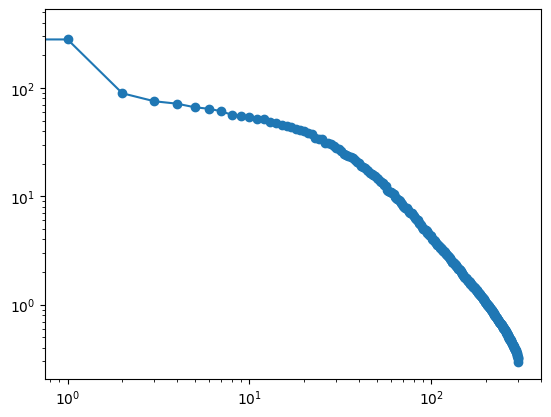

In [6]:
plt.plot(np.linalg.svd(datasets[-1]['xs'], full_matrices=False, compute_uv=False), '-o',)
plt.loglog()

/home/arthur/PycharmProjects/localdynamics/localdynamics/plotting/plot2.py:11: RuntimeWarning: All-NaN axis encountered
  sv = np.nanmax(sv, axis=-2)
/home/arthur/PycharmProjects/mdds/.venv12/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:1634: RuntimeWarning: All-NaN slice encountered
  return fnb._ureduce(a,


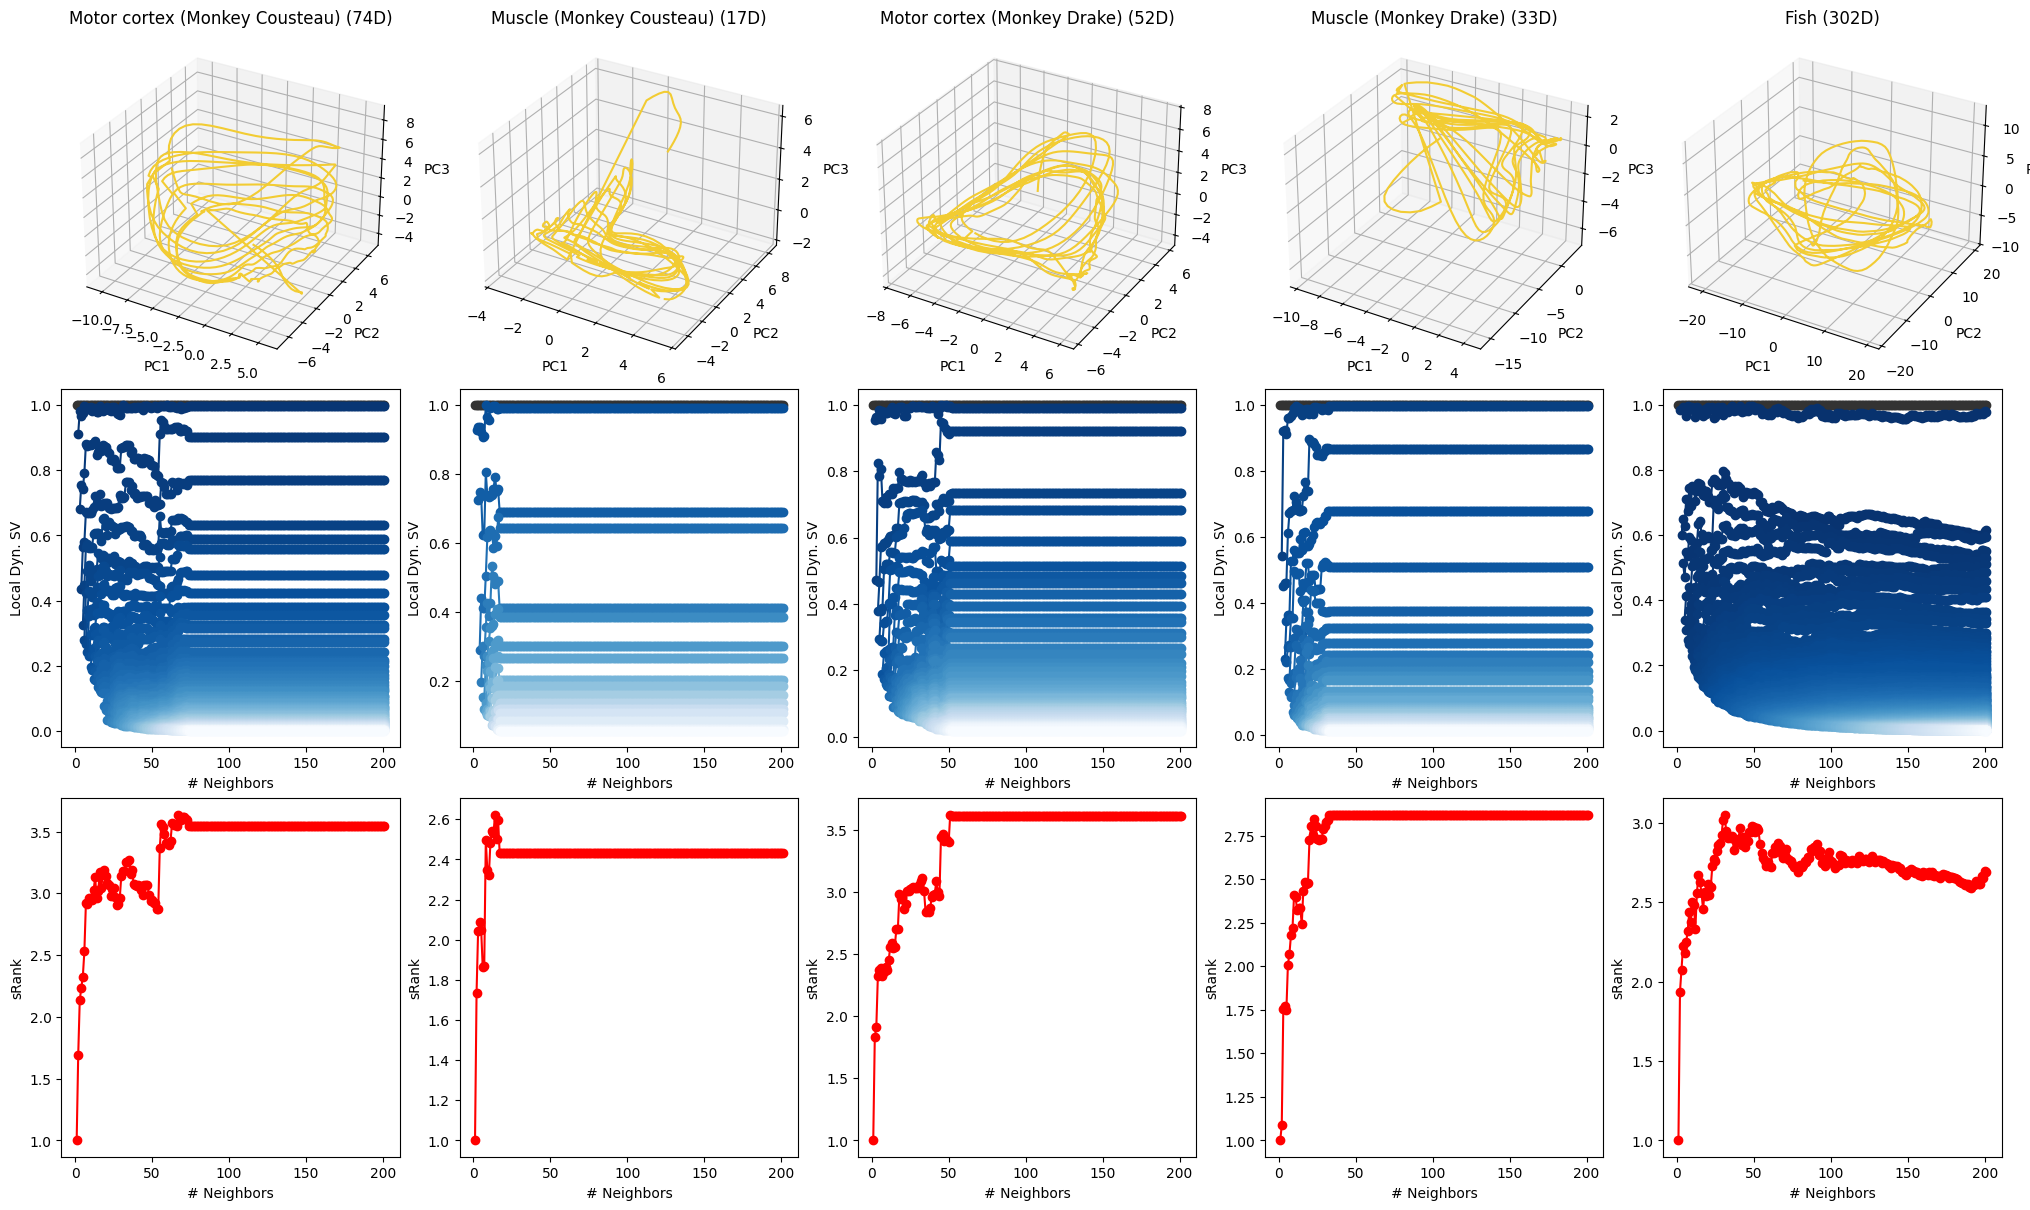

In [7]:
fig, axs = plot.get_axes_grid(cols=len(datasets), rows=3, rows_3d=[0], dpi=100)

for d, ax in zip(datasets, axs):
    ax[0].set_title(f'{d['name']} ({d['xs'].shape[-1]}D)')
    plot2.plot_latent(ax[0], d['xs'])
    plot2.plot_sv_barcode(ax[1], nb_neighbors, d['sv_local_dxs_dts'])
    plot2.plot_srank(ax[2], nb_neighbors, d['sv_local_dxs_dts'])
    
plt.show()